### Handling warnings and initial packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os

# Disable tokenizers parallelism to avoid the warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
!pip install -q -U watermark
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.1.0+cu121
transformers: 4.35.2



### Title & Configuration

In [4]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Data Exploration

In [5]:
train_path = '/content/train.csv'
test_path = '/content/test.csv'
val_path = '/content/val.csv'

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_val = pd.read_csv(val_path)

df_train.drop(df_train.columns.difference(['Data','Label']), 1, inplace=True)
df_test.drop(df_test.columns.difference(['Data','Label']), 1, inplace=True)
df_val.drop(df_val.columns.difference(['Data','Label']), 1, inplace=True)

df_train["Label"] = df_train['Label'].fillna(0).astype(np.int64)
df_test["Label"] = df_test['Label'].fillna(0).astype(np.int64)
df_val["Label"] = df_val['Label'].fillna(0).astype(np.int64)


print("Train data")
df_train.head(30)

Train data


,Data,Label
0,মেকাপ করতে করতে মুখের বর্তমান যে অবস্থা তাতে ম...,2
1,উচ্চবিত্ত পরিবারেও নানা কৌশলে যৌতুক দেয়া এবং ন...,1
2,দিদি সামনের চুল গুলা না রাখলে কী সমস্যা টা হত...,2
3,নষ্টা মেয়ে ছাড়া কখনো সিগারেট খেতে পারে না।,2
4,খানকী গুলা ঢাকা শহর তো নষ্ট করসে এখন কক্সবাজার...,2
5,সব মেয়েরাই ভূত একেকটা!,2
6,অপু তোমার সামনের রাস্তা টা বড় হয়ে গেছে মনে হয় ...,2
7,"দুঃসময়ে প্রথম যে মানুষটি পাশে দাঁড়ায়, চরম সিদ্...",1
8,নারীবান্ধব পরিবেশ তৈরি হয়েছে।,1
9,সবদিক থেকেই দেখা যায় আমাদের দেশের কন্যা-শিশুর...,1


In [6]:
print("Test data")
df_test.head(10)

Test data


,Data,Label
0,"কর্মক্ষেত্রে নারীর অংশগ্রহণ, কাজের পরিবেশ, মজু...",1
1,"এই বেটির বাবা টা যদি ধর্ষক না হইতো,তাহলে আজকে ...",2
2,মানুষ সুন্দর চেহারাকে কুৎসিত চেহারাই কিভাবে উপ...,2
3,ডাক্তারি পড়লে মেয়েকে ভালো বিয়ে দেয়া যাবে,2
4,কাউকে মেরে ফেলার ব্যাপারে সরকারের পদক্ষেপের পে...,0
5,তবে তারা ধীরে ধীরে গাড়ি চালিয়ে আসছে।,0
6,"মায়ের অনুপ্রেরণা, সহযোগিতাতেই আজকের আমার আমি।",1
7,শিক্ষিত মেয়ে মানেই আকাইম্মা,2
8,জামাগুলো খুলে ফেলো বেয়াদব বেটি কোথাকার।,2
9,"হিসাব করে দেখা গিয়েছে, কয়েকশত হাজার বর্গ কিল...",0


In [7]:
print("Validation data")
df_val.head(10)

Validation data


,Data,Label
0,আমি একদম ক্লিয়ার দেখতে পাচ্ছি আফার গোপন দু:খ গ...,2
1,ইনবক্স করলে তোরে জানাবোনে কথা বলে।,0
2,আমাদের সমাজে এখন মেয়েদের চাকরি করার প্রবণতা বে...,2
3,নারীদের ক্রিকেট খেলার কোন অধিকার নেই। এটা অনধি...,2
4,অনেকের মতে আজকের পাবলিক লাইব্রেরীর ধারণা আসলে ...,0
5,স্টেমিনার দিক থেকে পুরুষ নারী থেকে এগিয়ে আছে,2
6,তিনি বলেন তার প্রতিষ্ঠানের ফেসবুক পেইজে অনেকেই...,0
7,এ ঘটনা আমাদের গ্রামেই ঘটতে দেখেছি,0
8,স্কুলের নাটকগুলোতে অংশ নেবার সময়েই নিজের এই স...,0
9,সেটাই তো স্তন না দুললে ভূমিকম্প কেমনে হবে?,2


In [8]:
df_train=df_train.dropna()
df_train.shape

(10271, 2)

In [9]:
df_train[:]

,Data,Label
0,মেকাপ করতে করতে মুখের বর্তমান যে অবস্থা তাতে ম...,2
1,উচ্চবিত্ত পরিবারেও নানা কৌশলে যৌতুক দেয়া এবং ন...,1
2,দিদি সামনের চুল গুলা না রাখলে কী সমস্যা টা হত...,2
3,নষ্টা মেয়ে ছাড়া কখনো সিগারেট খেতে পারে না।,2
4,খানকী গুলা ঢাকা শহর তো নষ্ট করসে এখন কক্সবাজার...,2
...,...,...
10271,ছাগীদের আরেক নাম নারীবাদী।,2
10272,ডিভোর্সী মেয়ে বিয়ে করার চেয়ে মরে যাওয়াও ভালো।,2
10273,আফা যৌবন তো লাল টমেটো বানাইয়া হালাইছেন তাইলে।,2
10274,সৌদি আরবে পৌঁছে তিনি সোভিয়েত-সৌদি সম্পর্ককে আ...,0


In [10]:
df_test=df_test.dropna()
df_test.shape

(399, 2)

In [11]:
df_test[:]

,Data,Label
0,"কর্মক্ষেত্রে নারীর অংশগ্রহণ, কাজের পরিবেশ, মজু...",1
1,"এই বেটির বাবা টা যদি ধর্ষক না হইতো,তাহলে আজকে ...",2
2,মানুষ সুন্দর চেহারাকে কুৎসিত চেহারাই কিভাবে উপ...,2
3,ডাক্তারি পড়লে মেয়েকে ভালো বিয়ে দেয়া যাবে,2
4,কাউকে মেরে ফেলার ব্যাপারে সরকারের পদক্ষেপের পে...,0
...,...,...
394,পর্দা ফেটে বেচারি হেদায়েত পাইছে।,2
395,সিদ্ধান্ত: ঐ খাবার থেকেই সমস্যার উৎপত্তি হয়েছে।,0
396,"তাই তার কপাল ভাল যে, অভিনেতাদের আয় নির্ধারণের...",0
397,যে ঘরে মা নেই সে ঘরে কখনও ভালোবাসার পরশ থাকে না।,1


In [12]:
df_val=df_val.dropna()
df_val.shape

(499, 2)

In [13]:
df_val[:]

,Data,Label
0,আমি একদম ক্লিয়ার দেখতে পাচ্ছি আফার গোপন দু:খ গ...,2
1,ইনবক্স করলে তোরে জানাবোনে কথা বলে।,0
2,আমাদের সমাজে এখন মেয়েদের চাকরি করার প্রবণতা বে...,2
3,নারীদের ক্রিকেট খেলার কোন অধিকার নেই। এটা অনধি...,2
4,অনেকের মতে আজকের পাবলিক লাইব্রেরীর ধারণা আসলে ...,0
...,...,...
494,এইসব এর জন্য মেয়েরা নিজেরাই দায়ী। কোনো কিছু কর...,2
495,দেশের অধিকাংশ ক্ষেত্রেই নারীরাই নেতৃত্ব দিচ্ছেন।,1
496,"জেলা প্রশাসক, ইউএনও, পুলিশের ডিআইজি, পুলিশ সুপ...",1
497,মেয়েদের চেয়ে ছেলেরা দ্রুত যে কোন বিষয় বুঝতে পারে,2


In [14]:
df_train['Label'].value_counts()

2    3699
0    3365
1    3207
Name: Label, dtype: int64

In [15]:
df_test['Label'].value_counts()

2    153
0    132
1    114
Name: Label, dtype: int64

In [16]:
df_val['Label'].value_counts()

2    173
1    166
0    160
Name: Label, dtype: int64

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10271 entries, 0 to 10275
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    10271 non-null  object
 1   Label   10271 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 240.7+ KB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 398
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    399 non-null    object
 1   Label   399 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.4+ KB


In [19]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    499 non-null    object
 1   Label   499 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.7+ KB


In [20]:
class_names = ['neutral', 'positive','negative']

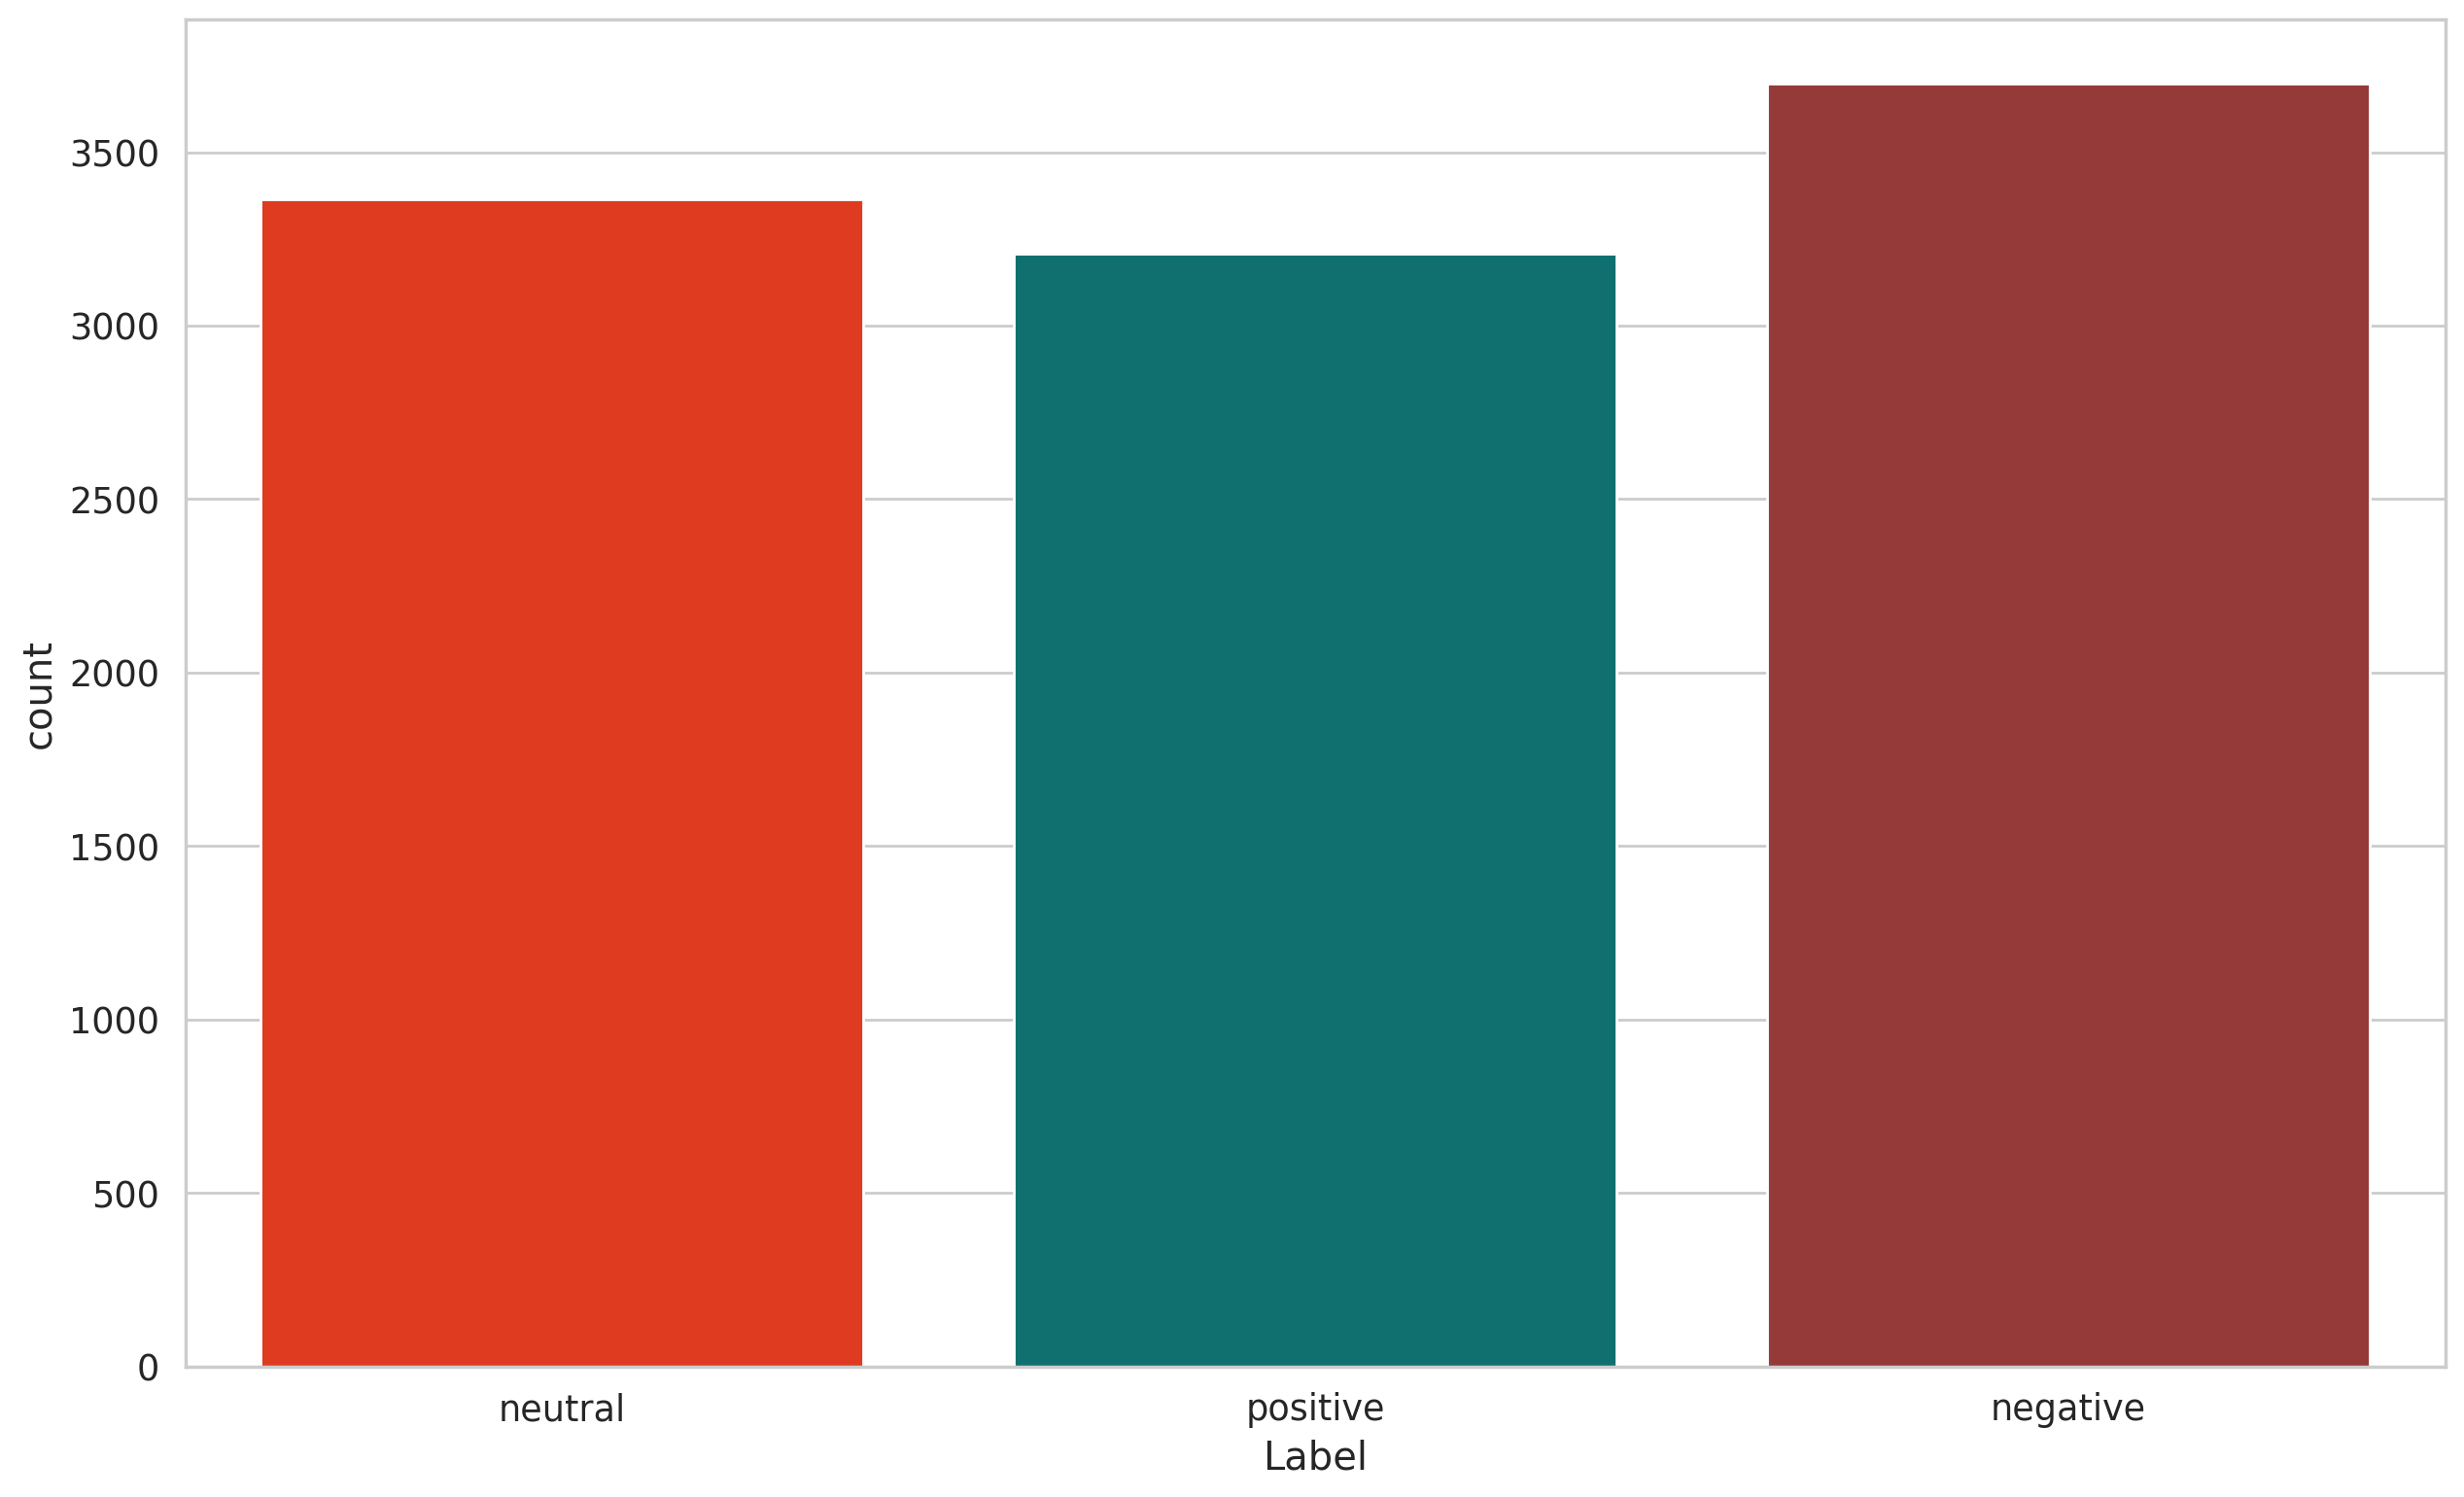

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(15, 9))

Toxic_count = df_train['Label'].value_counts()
sns.countplot(x='Label', data=df_train, hue='Label', palette=['#FF2400', 'teal', '#A52A2A', 'Seagreen'], legend=False)
labels = class_names
plt.gca().set_xticklabels(labels)

plt.show()


### Import Banglabert packages

In [22]:
from transformers import AutoTokenizer, AutoModel
from transformers import BertForMaskedLM, BertTokenizer, pipeline
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [23]:
PRE_TRAINED_MODEL_NAME = 'csebuetnlp/banglabert' #sagorsarker/bangla-bert-base #bert-base-multilingual-cased #csebuetnlp/banglabert #neuropark/sahajBERT

In [24]:
tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")#BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME) #AutoTokenizer.from_pretrained("csebuetnlp/banglabert") PreTrainedTokenizerFast.from_pretrained("neuropark/sahajBERT")

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [25]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-r9g5xm87
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-r9g5xm87
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6859 sha256=a2287771094f40de84da6288b3ae17c23ae57e8835edcbfd2c5cb659880d7a8a
  Stored in directory: /tmp/pip-ephem-wheel-cache-vfh2txrm/wheels/2e/79/9c/cd96d490298305d51d2da11484bb2c25fd1f759a6906708282
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186460 sha256=c08f9ad2fea0b0214f3bbc1bbecb7b9587c1871

In [26]:
from transformers import AutoModelForPreTraining, AutoTokenizer
from normalizer import normalize
import torch

In [27]:
MAX_LEN = 80

In [28]:
sample_txt= "আমি একদম ক্লিয়ার দেখতে পাচ্ছি"

In [29]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True,
  return_tensors='pt',

)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

#### Choosing Sequence Length

In [30]:
token_lens = []

for txt in df_train.Data:
    txt = normalize(txt)  # This normalization step is required before tokenizing the text
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))


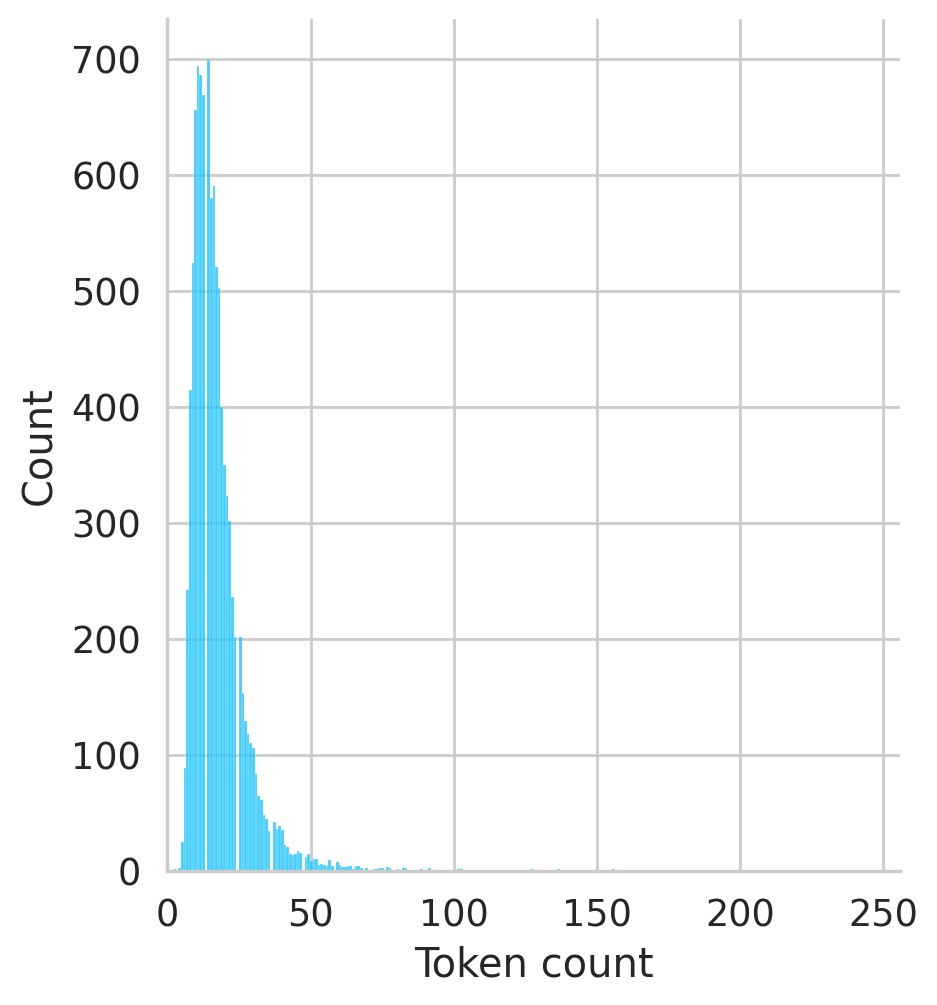

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming token_lens is a list of token counts
sns.displot(token_lens, kde=False)
plt.xlim([0, 256])
plt.xlabel('Token count')
plt.show()

In [32]:
class GPReviewDataset(Dataset):

  def __init__(self, comments, targets, tokenizer, max_len):
    self.comments = comments
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.comments)
  def __getitem__(self, item):
    review = str(self.comments[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'Data': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


In [33]:
df_train.shape, df_val.shape, df_test.shape

((10271, 2), (499, 2), (399, 2))

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    comments=df.Data.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,

  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4,
    shuffle=True
  )


In [35]:
BATCH_SIZE = 64

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([64, 80])
torch.Size([64, 80])
torch.Size([64])


In [38]:
bert_model = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME) #BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) # method name

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [39]:
!export LRU_CACHE_CAPACITY=1
!export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

In [40]:
torch.cuda.empty_cache()

In [41]:
last_hidden_state = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [42]:
PRE_TRAINED_MODEL_NAME

'csebuetnlp/banglabert'

In [43]:
bert_model.config.hidden_size

768

In [44]:
last_hidden_state

ElectraForPreTrainingOutput(loss=None, logits=tensor([[-10.6180,  -3.1433,  -2.4670,   0.2849,  -3.4841,  -3.0480, -10.6181,
          -0.2494,  -0.0517,  -0.6464,  -1.7271,  -1.7865,  -0.8170,  -1.3561,
           0.0299,   0.7829,   0.7557,   2.0890,  -0.2304,   0.1178,  -0.9789,
           3.4368,   1.5699,   0.2463,   0.5140,   0.4415, -10.7468,  -1.1602,
          -0.6470,  -0.7606,  -4.0054,   0.0294,  -1.3347,  -4.0220,  -4.1570,
          -0.4818,  -3.7449,  -7.7299,  -1.8813,  -1.8794,  -0.7807,  -2.4238,
          -1.0560,   0.3711,  -1.8764,   0.2527, -10.7313, -10.5477,   0.0387,
          -0.4149,   0.9826,  -0.9389,   2.6853,   3.3343,  -4.0777,   0.3230,
          -3.2623, -10.5658,  -3.9119,  -0.7865,  -0.3537,  -2.0726,  -3.1930,
          -3.6292,  -4.0831,   0.1141, -10.5354, -10.5795,  -3.2874,   0.1619,
          -0.5057,  -1.6379,  -0.9556,   3.9639,  -2.5630,   1.1007,  -2.0315,
          -8.2157,  -0.0188,  -0.7232]], grad_fn=<SqueezeBackward1>), hidden_states=N

In [45]:
class genderBiasClassifier(nn.Module):

    def __init__(self, n_classes):
        super(genderBiasClassifier, self).__init__()
        self.electra = AutoModelForPreTraining.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(80, n_classes)  # Adjust the input size

    def forward(self, input_ids, attention_mask):
        outputs = self.electra(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        pooled_output = outputs.logits  # Access logits for pooled output
        output = self.drop(pooled_output)
        return self.out(output)

In [46]:
model = genderBiasClassifier(len(class_names))
model = model.to(device)

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([64, 80])
torch.Size([64, 80])


In [48]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[7.8997e-01, 6.2612e-04, 2.0941e-01],
        [9.9991e-01, 1.4992e-05, 7.0242e-05],
        [2.2371e-06, 3.2841e-03, 9.9671e-01],
        [1.0369e-04, 3.4444e-07, 9.9990e-01],
        [9.9605e-01, 3.0543e-05, 3.9232e-03],
        [3.4878e-02, 8.3610e-03, 9.5676e-01],
        [3.1584e-01, 6.0838e-04, 6.8356e-01],
        [9.8019e-01, 7.9450e-04, 1.9012e-02],
        [4.4917e-03, 9.2274e-06, 9.9550e-01],
        [9.9542e-01, 1.4412e-03, 3.1428e-03],
        [3.9482e-02, 8.5394e-03, 9.5198e-01],
        [9.9230e-01, 3.6966e-10, 7.7007e-03],
        [1.8418e-03, 2.8495e-02, 9.6966e-01],
        [4.4051e-03, 7.8091e-02, 9.1750e-01],
        [8.7143e-01, 9.6352e-02, 3.2217e-02],
        [7.9198e-03, 8.4489e-08, 9.9208e-01],
        [9.9879e-01, 9.3571e-06, 1.2044e-03],
        [9.0457e-01, 9.8508e-06, 9.5418e-02],
        [7.9109e-05, 7.5792e-04, 9.9916e-01],
        [3.1121e-04, 3.6408e-04, 9.9932e-01],
        [6.9724e-01, 1.3753e-02, 2.8901e-01],
        [8.5313e-01, 2.8897e-04, 1

## Training the model

In [50]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=True)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=4,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)


In [51]:
from tqdm import tqdm
import torch.nn as nn
import numpy as np

def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  #tqdm for progress monitoring
  data_loader = tqdm(data_loader, desc="Training", unit="batch")

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    # Update tqdm description with the current loss
    data_loader.set_postfix(loss=np.mean(losses))

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
from tqdm import tqdm
import torch
import numpy as np

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0


    data_loader = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

            # Update tqdm description with the current loss
            data_loader.set_postfix(loss=np.mean(losses))

    return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'\nTrain loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'\nVal   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.8203191490647215 accuracy 0.6742284100866517


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.30156096909195185 accuracy 0.8857715430861722

Epoch 2/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.30408509945647316 accuracy 0.8921234543861357


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.22828113567084074 accuracy 0.9178356713426853

Epoch 3/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.19043638883447794 accuracy 0.9336968162788433


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.19722798001021147 accuracy 0.9298597194388777

Epoch 4/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.1203510030548765 accuracy 0.9593028916366468


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.33171211555600166 accuracy 0.9178356713426853

Epoch 5/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.06925585253383987 accuracy 0.9758543471911206


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.4297303967177868 accuracy 0.9278557114228456

Epoch 6/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.04017300772522605 accuracy 0.987732450589037


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.6113664135336876 accuracy 0.9118236472945891

Epoch 7/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.026831771022392877 accuracy 0.991724272222763


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.5462596900761127 accuracy 0.9318637274549098

Epoch 8/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.024872168276284717 accuracy 0.9927952487586408


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.6848120801150799 accuracy 0.9218436873747494

Epoch 9/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.017557789864214603 accuracy 0.994742478823873


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.7235857471823692 accuracy 0.9198396793587174

Epoch 10/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.012164757171224026 accuracy 0.9967870703923668


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.9322736486792564 accuracy 0.9198396793587174

Epoch 11/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.01180686969985804 accuracy 0.99698179339889


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.8338891677558422 accuracy 0.9258517034068136

Epoch 12/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.0068826280264157385 accuracy 0.9981501314380293


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.7581727616488934 accuracy 0.9338677354709418

Epoch 13/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.00750721634508483 accuracy 0.9979554084315061


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.8550622863695025 accuracy 0.9358717434869739

Epoch 14/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.004201948229436337 accuracy 0.9985395774510758


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.9741479195654392 accuracy 0.9318637274549098

Epoch 15/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.003915101029095766 accuracy 0.9988316619608606


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 1.081254169344902 accuracy 0.9158316633266532

Epoch 16/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.0045744294741671574 accuracy 0.9984422159478142


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.8844936229288578 accuracy 0.9218436873747494

Epoch 17/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.004174835153814388 accuracy 0.9990263849673838


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 0.9763755425810814 accuracy 0.9238476953907815

Epoch 18/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.002005584007720079 accuracy 0.9994158309804303


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 1.031256478279829 accuracy 0.9198396793587174

Epoch 19/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.005224917846039533 accuracy 0.9991237464706455


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 1.012545496225357 accuracy 0.9218436873747494

Epoch 20/20
----------


Training:   0%|          | 0/161 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Train loss 0.0016384732076935343 accuracy 0.9995131924836919


Evaluating:   0%|          | 0/8 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio


Val   loss 1.0063845291733742 accuracy 0.9238476953907815

CPU times: user 29min 11s, sys: 15min 46s, total: 44min 57s
Wall time: 46min


In [54]:
model=genderBiasClassifier(len(class_names))

In [55]:
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)

## Evaluation

In [56]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Evaluating:   0%|          | 0/7 [00:00<?, ?batch/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncatio

0.9072681704260651

In [57]:
def get_predictions(model, data_loader):
  model = model.eval()

  toxic_comments = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["Data"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      toxic_comments.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return toxic_comments, predictions, prediction_probs, real_values

In [58]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-s

### Classification report

In [59]:
print(classification_report(y_test, y_pred, target_names=class_names,digits=4))

              precision    recall  f1-score   support

     neutral     0.9675    0.9015    0.9333       132
    positive     0.8655    0.9035    0.8841       114
    negative     0.8917    0.9150    0.9032       153

    accuracy                         0.9073       399
   macro avg     0.9082    0.9067    0.9069       399
weighted avg     0.9093    0.9073    0.9077       399



#### Confusion Matrix

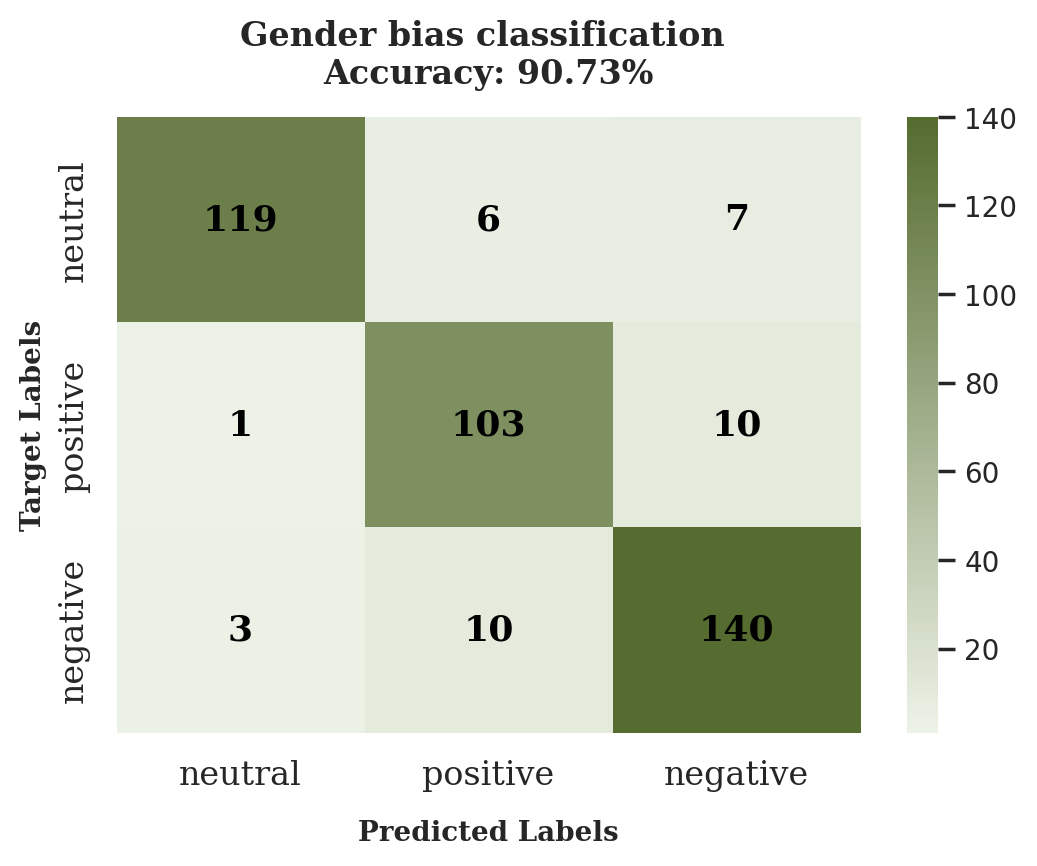

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy_percentage = accuracy * 100

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.light_palette("DarkOliveGreen", as_cmap=True)
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
font2 = {'family': 'Serif', 'weight': 'bold', 'size': 10}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,
                      xticklabels=class_names, yticklabels=class_names,
                      annot_kws={"family": "Serif", 'color':'black','weight': 'bold', 'size': 13})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font2)
heatmap.set_ylabel('Target Labels', fontdict=font2)
heatmap.set_title('Gender bias classification \nAccuracy: {:.2f}%'.format(accuracy_percentage),
                  fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space


plt.show()

In [62]:
idx = 40

review_text = y_review_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [63]:
print("\n".join(wrap(review_text)))
print()
print(f'True Label: {class_names[true_label]}')

নারী মানে হচ্ছে তাদের নিজের প্রতি কোন কন্ট্রোল নেই।

True Label: negative


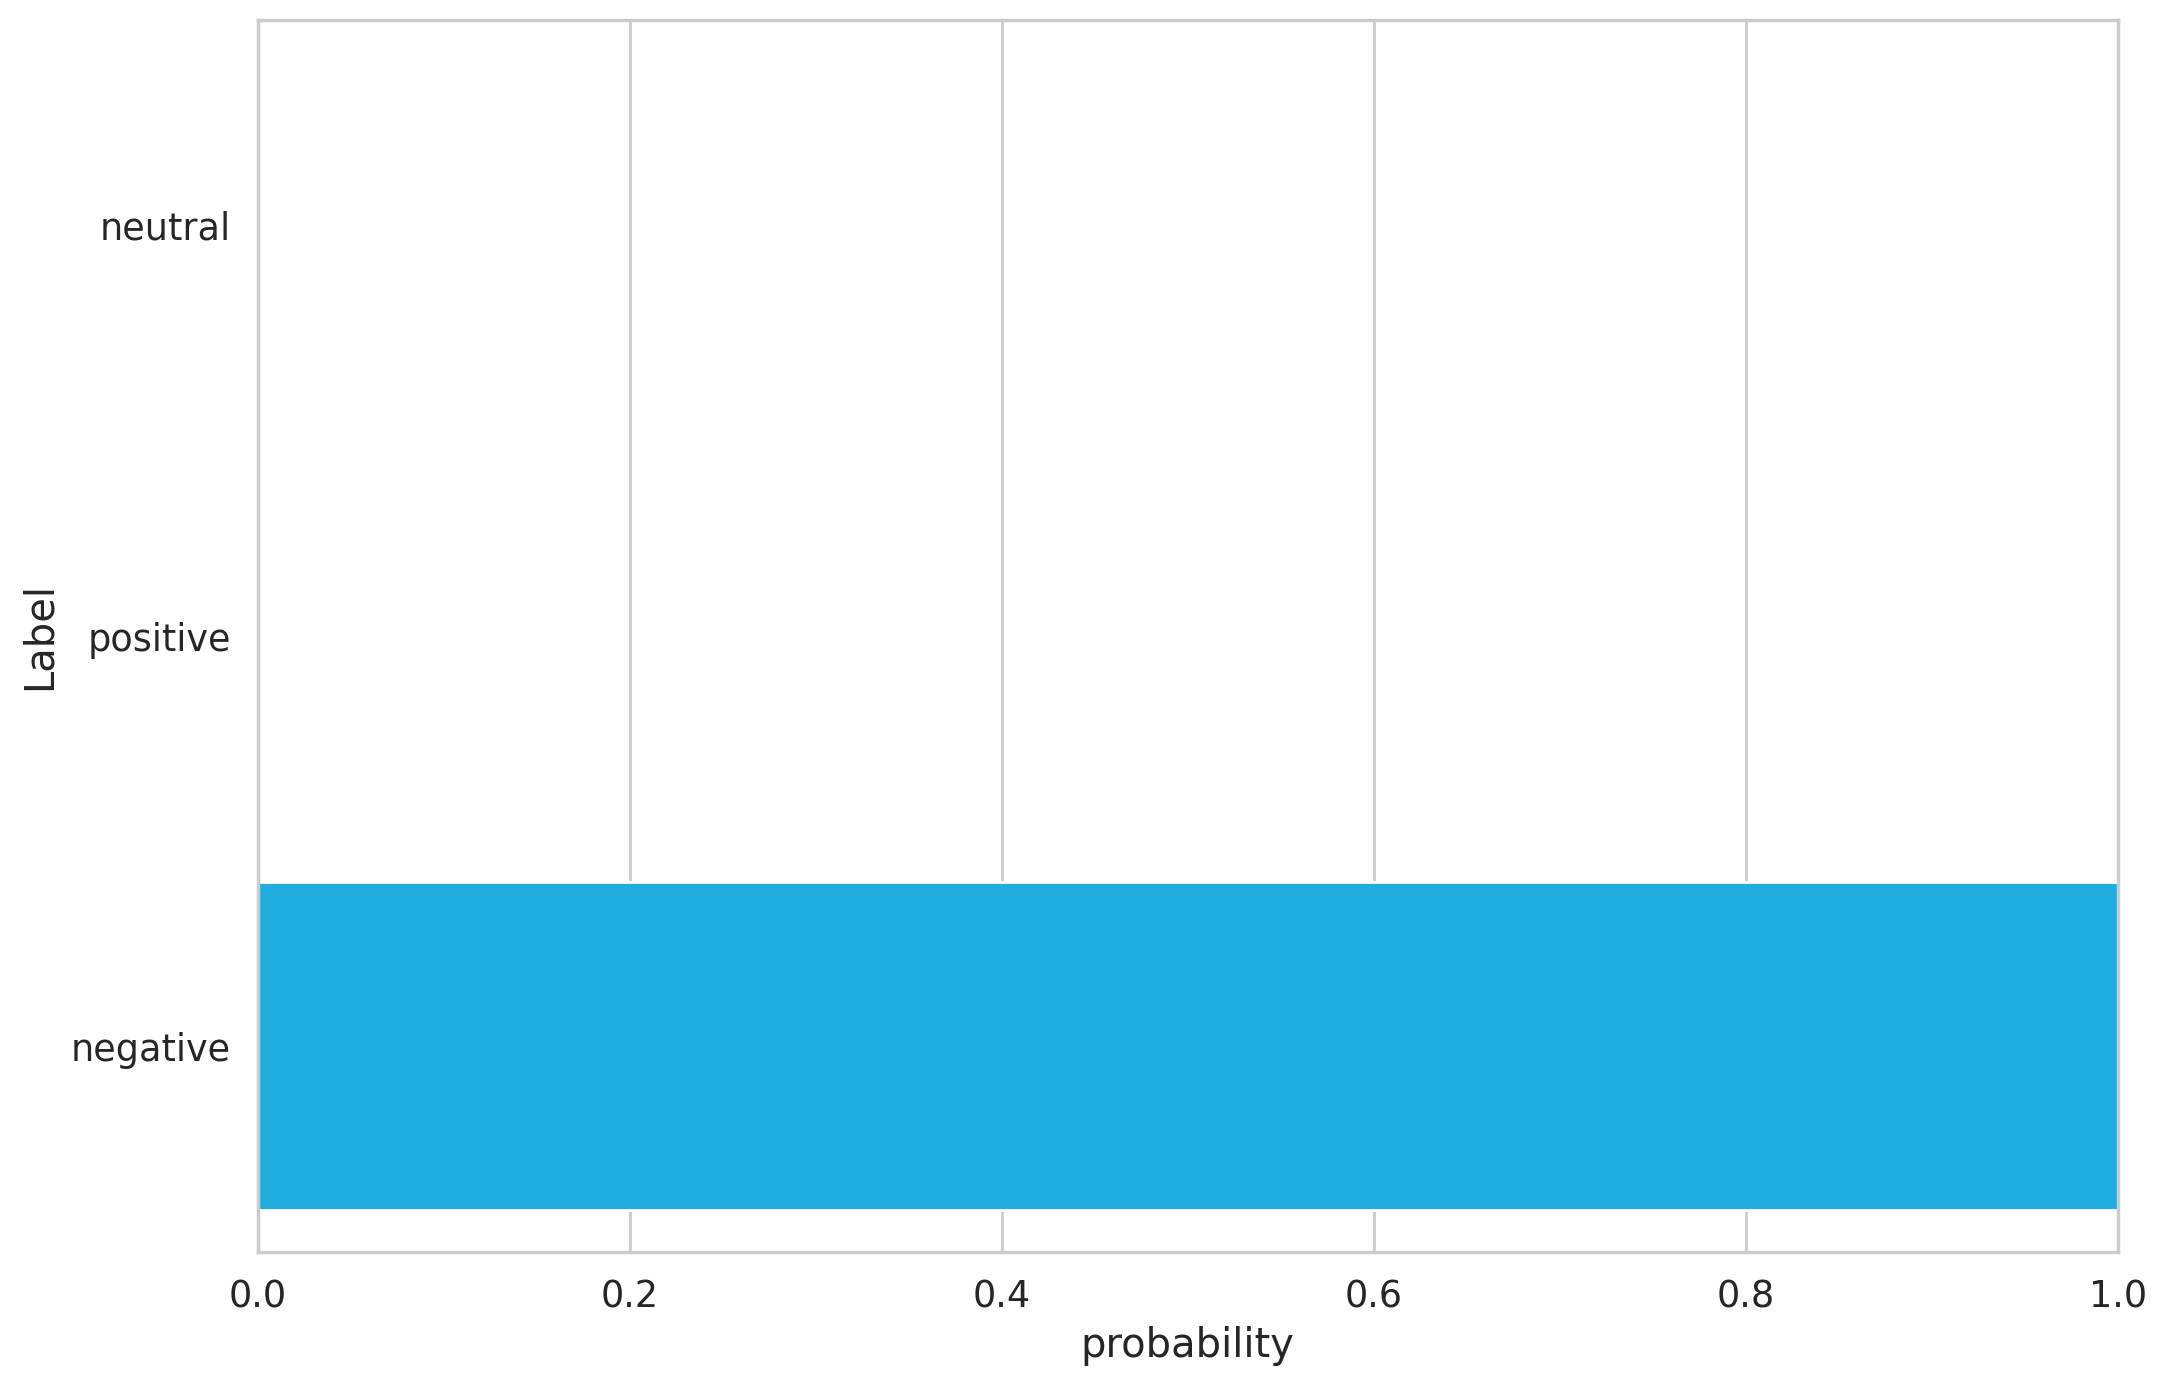

In [64]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Label')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [65]:
Raw_Text = "তিনি অনেক ভালো লেখেন"

In [66]:
encoded_review = tokenizer.encode_plus(
  Raw_Text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [67]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Raw Text: {Raw_Text}')
print(f'Prediction  : {class_names[prediction]}')

Raw Text: তিনি অনেক ভালো লেখেন
Prediction  : neutral


In [97]:
review_text = "মেয়েরা এসব পারে না"

In [98]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [99]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Context text: {review_text}')
print(f'Prediction   : {class_names[prediction]}')

Context text: মেয়েরা এসব পারে না
Prediction   : negative
